<a href="https://colab.research.google.com/github/Sergey-Kiselev-dev/ML_sem_pub/blob/main/ML_04_selfedu_ml_44a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prediction Intervals for Gradient Boosting Regression
================
This example shows how quantile regression can be used to create prediction intervals. See Features in Histogram Gradient Boosting Trees for an example showcasing some other features of HistGradientBoostingRegressor.

Generate some data for a synthetic regression problem by applying the function f to uniformly sampled random inputs.

In [14]:
#44. Градиентный бустинг и стохастический градиентный бустинг | Машинное обучение
# https://www.youtube.com/watch?v=nvk2YAq4_v0&list=PLA0M1Bcd0w8zxDIDOTQHsX68MCDOAJDtj&index=45
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-quantile-py

import numpy as np

from sklearn.model_selection import train_test_split


def f(x):
    """The function to predict."""
    return x * np.sin(x)


rng = np.random.RandomState(42)
X = np.atleast_2d(rng.uniform(0, 10.0, size=1000)).T
expected_y = f(X).ravel()

To make the problem interesting, we generate observations of the target y as the sum of a deterministic term computed by the function f and a random noise term that follows a centered log-normal. To make this even more interesting we consider the case where the amplitude of the noise depends on the input variable x (heteroscedastic noise).

The lognormal distribution is non-symmetric and long tailed: observing large outliers is likely but it is impossible to observe small outliers.

In [15]:
sigma = 0.5 + X.ravel() / 10
noise = rng.lognormal(sigma=sigma) - np.exp(sigma**2 / 2)
y = expected_y + noise

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Fitting non-linear quantile and least squares regressors
=========
Fit gradient boosting models trained with the quantile loss and alpha=0.05, 0.5, 0.95.

The models obtained for alpha=0.05 and alpha=0.95 produce a 90% confidence interval (95% - 5% = 90%).

The model trained with alpha=0.5 produces a regression of the median: on average, there should be the same number of target observations above and below the predicted values.

In [16]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_pinball_loss, mean_squared_error

all_models = {}
common_params = dict(
    learning_rate=0.05,
    n_estimators=200,
    max_depth=2,
    min_samples_leaf=9,
    min_samples_split=9,
)
for alpha in [0.05, 0.5, 0.95]:
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha, **common_params)
    all_models["q %1.2f" % alpha] = gbr.fit(X_train, y_train)

Notice that HistGradientBoostingRegressor is much faster than GradientBoostingRegressor starting with intermediate datasets (n_samples >= 10_000), which is not the case of the present example.

For the sake of comparison, we also fit a baseline model trained with the usual (mean) squared error (MSE).

Create an evenly spaced evaluation set of input values spanning the [0, 10] range.

In [17]:
gbr_ls = GradientBoostingRegressor(loss="squared_error", **common_params)
all_models["mse"] = gbr_ls.fit(X_train, y_train)

xx = np.atleast_2d(np.linspace(0, 10, 1000)).T

Plot the true conditional mean function f, the predictions of the conditional mean (loss equals squared error), the conditional median and the conditional 90% interval (from 5th to 95th conditional percentiles).

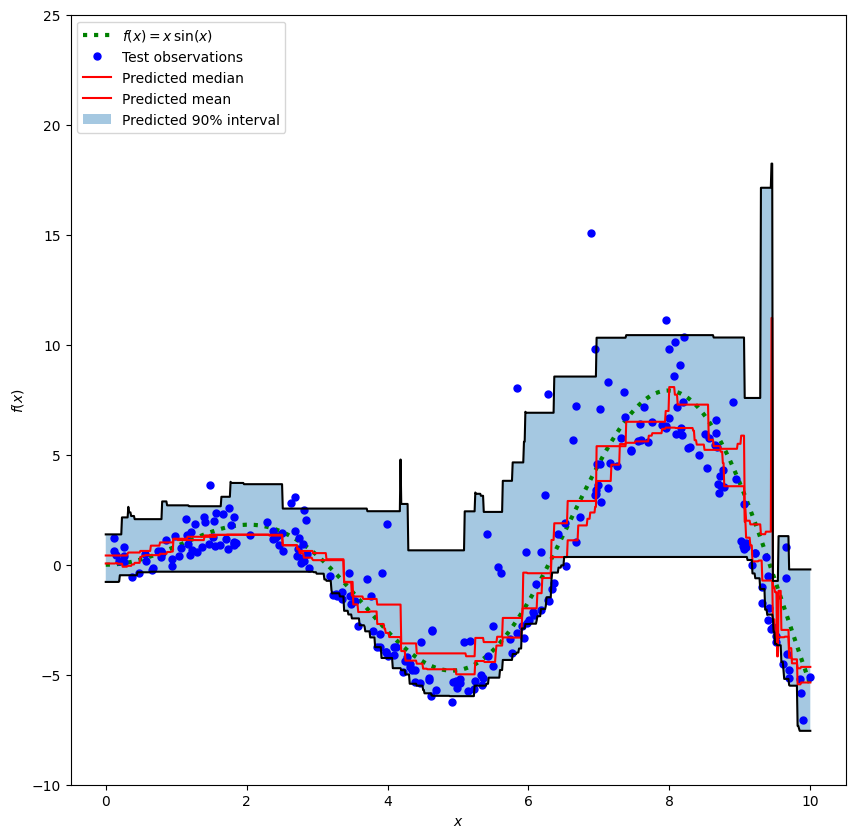

In [13]:
import matplotlib.pyplot as plt

y_pred = all_models["mse"].predict(xx)
y_lower = all_models["q 0.05"].predict(xx)
y_upper = all_models["q 0.95"].predict(xx)
y_med = all_models["q 0.50"].predict(xx)

fig = plt.figure(figsize=(10, 10))
plt.plot(xx, f(xx), "g:", linewidth=3, label=r"$f(x) = x\,\sin(x)$")
plt.plot(X_test, y_test, "b.", markersize=10, label="Test observations")
plt.plot(xx, y_med, "r-", label="Predicted median")
plt.plot(xx, y_pred, "r-", label="Predicted mean")
plt.plot(xx, y_upper, "k-")
plt.plot(xx, y_lower, "k-")
plt.fill_between(
    xx.ravel(), y_lower, y_upper, alpha=0.4, label="Predicted 90% interval"
)
plt.xlabel("$x$")
plt.ylabel("$f(x)$")
plt.ylim(-10, 25)
plt.legend(loc="upper left")
plt.show()